In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
prod_data = pd.read_csv('production_data.csv')
wells_data =  pd.read_csv('wellsData.csv')
op_aliasing_data = pd.read_csv('operator_aliasing.csv')

C:\Users\Dell\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Dropping duplicates from prod_data 
prod_data = prod_data.drop_duplicates(subset=['API', 'Month', 'Year'], keep='last', inplace=False)

In [4]:
# dropping unnecessary columns from tables
cols = ['API', 'Year', 'Month', 'Liquid', 'Gas', 'RatioGasOil']
prod_data = prod_data[cols]

cols = ['API', 'SpudDate', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

cols = ['Name', 'Alias']
op_aliasing_data = op_aliasing_data[cols]

In [5]:
# adding zeros to API
wells_data['API'] = (wells_data['API']).astype(str)
wells_data['API'] = wells_data['API'].apply(lambda x: x.zfill(14))

In [6]:
# adding zeros to API
prod_data['API'] = (prod_data['API']).astype(str)
prod_data['API'] = prod_data['API'].apply(lambda x: x.zfill(14))

In [7]:
# renaming operators
alias_dict = dict(zip(op_aliasing_data.Name, op_aliasing_data.Alias))
wells_data['operatorNameIHS'] = wells_data['operatorNameIHS'].map(alias_dict).fillna(wells_data['operatorNameIHS'])

In [8]:
# storing peak records 
idx_max = prod_data.groupby(['API'])['Liquid'].transform('max') == prod_data['Liquid']
max_month_prod_data = prod_data[idx_max].drop_duplicates(subset='API', keep='first', inplace=False)
list_indices = ['API', 'Year', 'Month', 'Liquid']
max_month_prod_data = max_month_prod_data[list_indices]
max_month_prod_data = max_month_prod_data.rename(columns={"Year": "Max_Year", "Month": "Max_Month", "Liquid": "Max_Liquid"})

In [9]:
# merging the two dataframes to get max month and max year
new_prod_data_orig = prod_data.merge(max_month_prod_data, on='API')

In [10]:
# Remove Pre-Peak Months (clean up)
new_prod_data = new_prod_data_orig[((new_prod_data_orig['Year'] == new_prod_data_orig['Max_Year']))]
new_prod_data = new_prod_data[(new_prod_data['Month'] >= new_prod_data['Max_Month'])]

new_prod_data2 = new_prod_data_orig[((new_prod_data_orig['Year'] > new_prod_data_orig['Max_Year']))]
new_prod_data3 = new_prod_data.append(new_prod_data2)

In [11]:
# calculates month index
def calc_month_index(max_year, max_month, year, month):
    return (12 - max_month + (year - max_year - 1)*12 + month) * (year != max_year) + (year == max_year) * (month - max_month) + 1 

In [12]:
# adding month index column to post peak production data
new_prod_data3['index'] = calc_month_index(new_prod_data3['Max_Year'], new_prod_data3['Max_Month'], new_prod_data3['Year'], new_prod_data3['Month'])
indexed_prod_data = new_prod_data3

## Problems encountered

- 0 max liquid production, fixed by setting first month as peek month

- missing months data in indexing months, fixed by super smart indexing equation

- missing month data in plotting, will be fixed by moving average inshaAllah

- CompletionDate removed Nulls and replaced them with Non-null Spuddates + six months

- removed duplicate entries for API, Month, Year by keeping the last updated one

- removed null spuddates and null completion dates from wells_data

- Missing APIs in wells_data, but existing in prod data and vice versa?

In [13]:
# removed nullified SpudDates and CompletionDates
wells_data = wells_data[~((wells_data['SpudDate'].isnull()) & (wells_data['CompletionDate'].isnull()))]

In [14]:
# replacing null CompletionDates with SpudDates + six months
wells_data['SpudDate'] = pd.to_datetime(wells_data['SpudDate'])
wells_data['CompletionDate'] = pd.to_datetime(wells_data['CompletionDate'])
wells_data.loc[wells_data['CompletionDate'].isnull(), 'CompletionDate'] = wells_data['SpudDate'] + timedelta(days=170) 

In [15]:
# Dropping SpudDate column
cols = ['API', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

In [16]:
# table for holding 4 basins of interest
wells_data_4basins = wells_data[wells_data['BasinName'] == 'DENVER BASIN']
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'PERMIAN BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'ANADARKO BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'WILLISTON BASIN'])
wells_data_4basins['API'] = wells_data_4basins['API'].astype(str)

In [17]:
# merging wells with indexed production data
indexed_wells_4basins = wells_data_4basins.merge(indexed_prod_data, on='API')

In [18]:
# returns statistics for first plot
def get_stats(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)]
    group_liquid = group["Liquid"]
    mean = group_liquid.mean()
    median = group_liquid.median()
    perct = group_liquid.quantile(.9)
    liquid = group_liquid
    return [[mean], [median], [perct], liquid]

In [19]:
# 2014 split
pre2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] < '2014-01-01']
post2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] >= '2014-01-01']
indices = np.arange(36) + 1
basins = ["ANADARKO BASIN","DENVER BASIN", "PERMIAN BASIN", "WILLISTON BASIN"]

# calculating stats
all_stats_pre = np.array([[get_stats(y, x, pre2014) for x in indices] for y in basins]) 
all_stats_post = np.array([[get_stats(y, x, post2014) for x in indices] for y in basins]) 

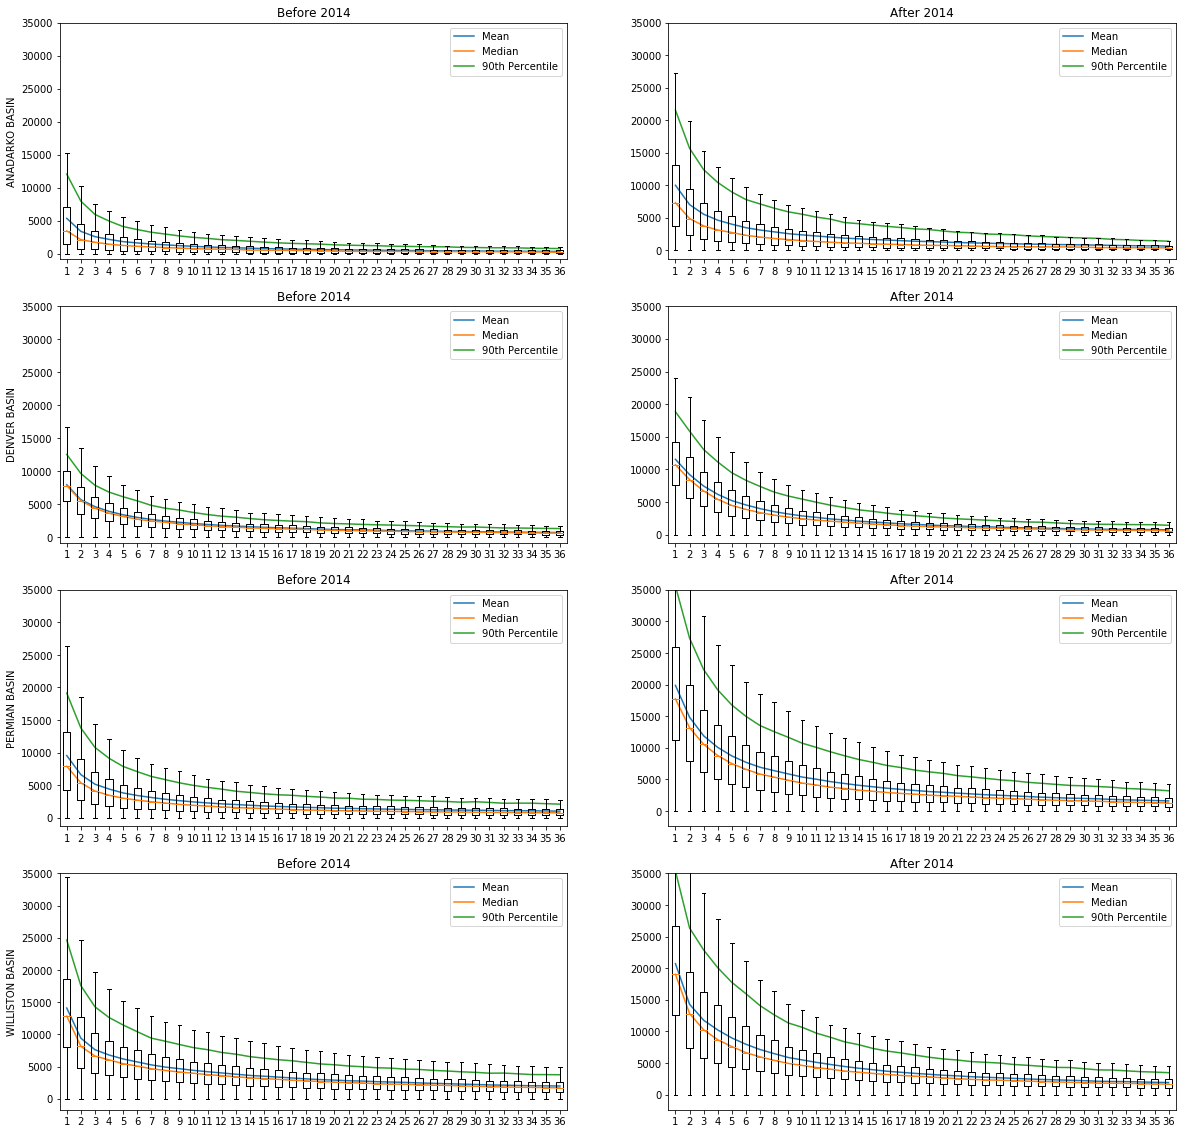

In [20]:
plt.rcParams["figure.figsize"]=20,20

idx = 1
for i in range(len(basins)):

    ax1 = plt.subplot(4,2,idx)
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,0]), label="Mean")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,1]), label="Median")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,2]), label="90th Percentile")
    ax1.boxplot(list(all_stats_pre[i,:,3]), showfliers=False)
    ax1.set_ylim(top=35000)
    ax1.legend()
    ax1.set_title('Before 2014')
    ax1.set_ylabel(basins[i])
    idx += 1

    ax2 = plt.subplot(4,2,idx)
    ax2.plot(indices, np.hstack(all_stats_post[i,:,0]), label="Mean")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,1]), label="Median")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,2]), label="90th Percentile")
    ax2.boxplot(list(all_stats_post[i,:,3]), showfliers=False)
    ax2.set_ylim(top=35000)
    ax2.set_title('After 2014')
    ax2.legend()
    
    idx += 1
    
plt.savefig('part1.png')



In [21]:
# #remove months larger than 60 old method
five_years_data = indexed_wells_4basins
five_years_data['max_index_five_years'] = five_years_data['index'].groupby(five_years_data['API']).transform("max")
five_years_data = five_years_data[five_years_data['max_index_five_years'] >= 60]
five_years_data = five_years_data[five_years_data['index'] <= 60]

Method 2 for calculating 5 years data

In [22]:
# # removing wells from after Feb 2014 [METHOD 2]
# five_years_data = indexed_wells_4basins[(indexed_wells_4basins['Max_Year'] < 2014) |((indexed_wells_4basins['Max_Year'] == 2014) & (indexed_wells_4basins['Max_Month'] == 1))] 
# five_years_data = five_years_data[five_years_data['index'] <= 60]

In [23]:
# returns production for given basin over 5 years as percentages
def cumm_prod_basin_year(basin, table): 
    total = table[(table['BasinName'] == basin)]
    total_liquid = total["Liquid"].sum()
    percents = np.zeros(5)
    for year in range(5):
        lower = (year)*12
        upper = (year + 1)*12
        group = total[(total['index'] > lower) & (total['index'] <= upper)]['Liquid']
        group_liquid = group.sum()
        percents[year] = ((group_liquid*100)/total_liquid)                
        
    return percents
    

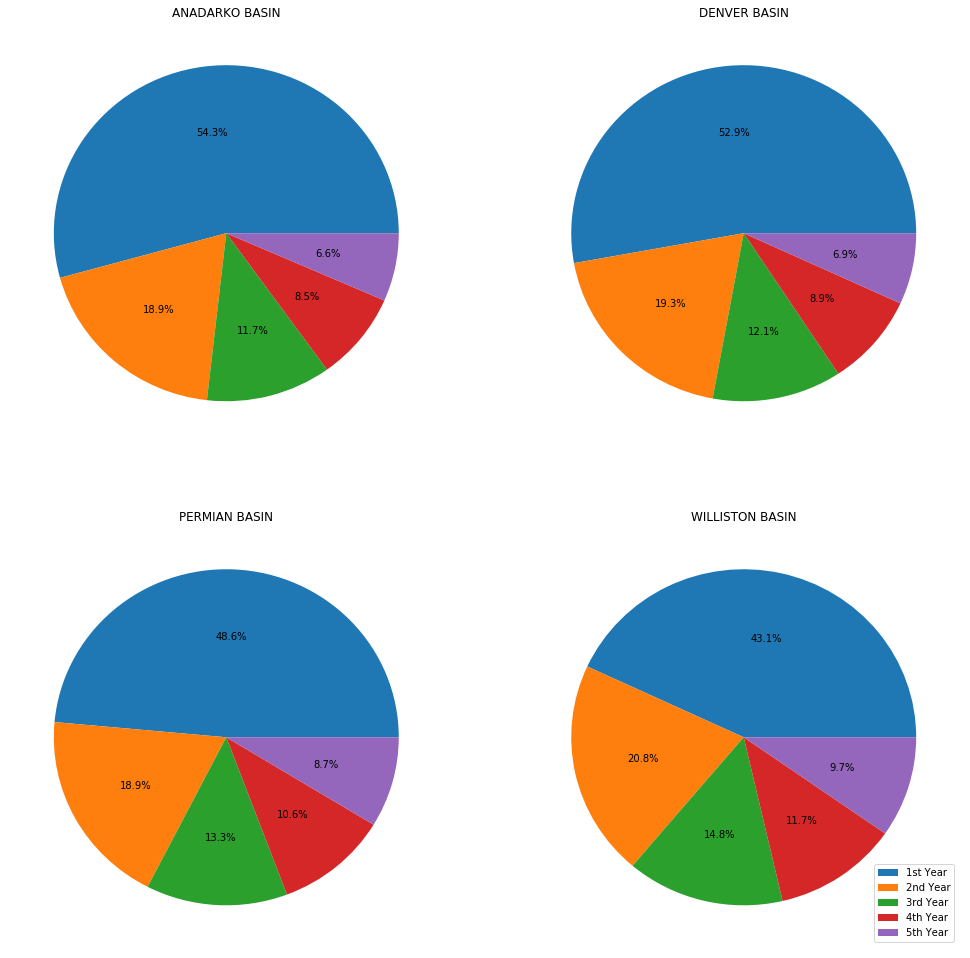

In [24]:
percentages = [cumm_prod_basin_year(y, five_years_data) for y in basins ]

plt.rcParams["figure.figsize"]=17,17
labels = ['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year']

for i in range(len(basins)):

    ax1 = plt.subplot(2,2,i+1)
    ax1.pie(percentages[i], autopct='%1.1f%%', shadow=False)
    ax1.set_title(basins[i])

plt.legend(labels, loc=4)
plt.savefig('Plot2.png')

In [26]:
# returns 5 years cumulative oil and gas production for a given basin
def cumm_prod_wells(table, basin):
    total = table[(table['BasinName'] == basin)]
    liq = total.groupby(total['API'])['Liquid'].sum()
    gas = total.groupby(total['API'])['Gas'].sum()
    return liq, gas

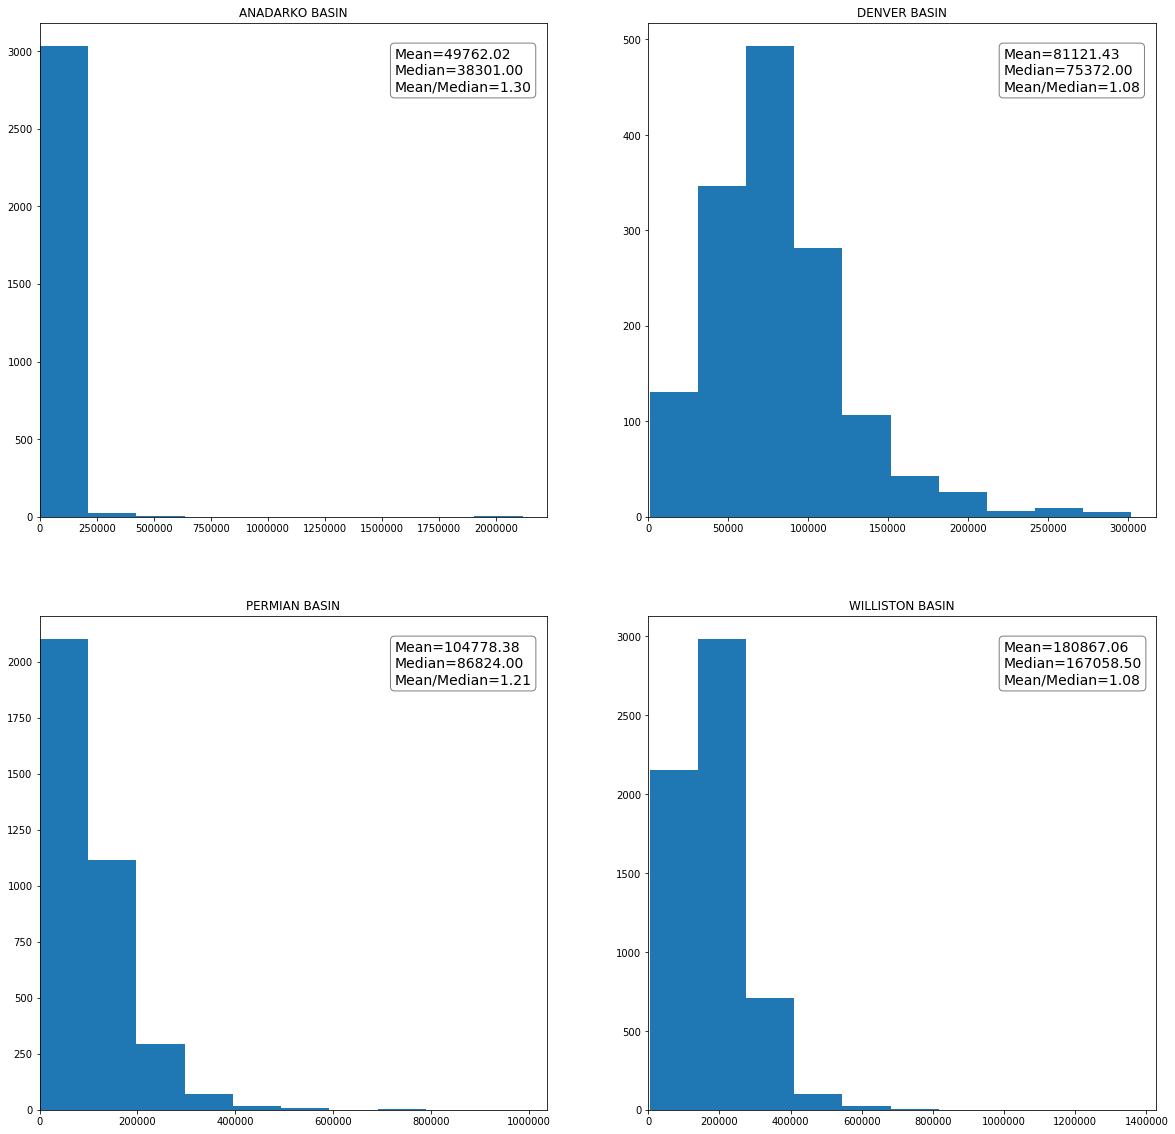

In [27]:


plt.rcParams["figure.figsize"] = 20,20
vals = np.array([cumm_prod_wells(five_years_data, y) for y in basins])

liq = vals[:, 0]
gas = vals[:, 1]

for i in range(len(basins)):
    ax1 = plt.subplot(2,2,i+1)
    ax1.hist(liq[i])
    ax1.set_title(basins[i])
    ax1.set_xlim(left=0)
    mean = liq[i].mean()
    median = liq[i].median()
    mean_med = mean/median
    
    textstr = 'Mean=' + str('%.2f'%mean) + '\n'+'Median=' + str('%.2f'%median)+ '\n'+'Mean/Median='+ str('%.2f'%mean_med)
    props = dict(boxstyle='round',facecolor='white', alpha=0.5)
    ax1.text(0.7, 0.95, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
plt.savefig('Plot3.png')

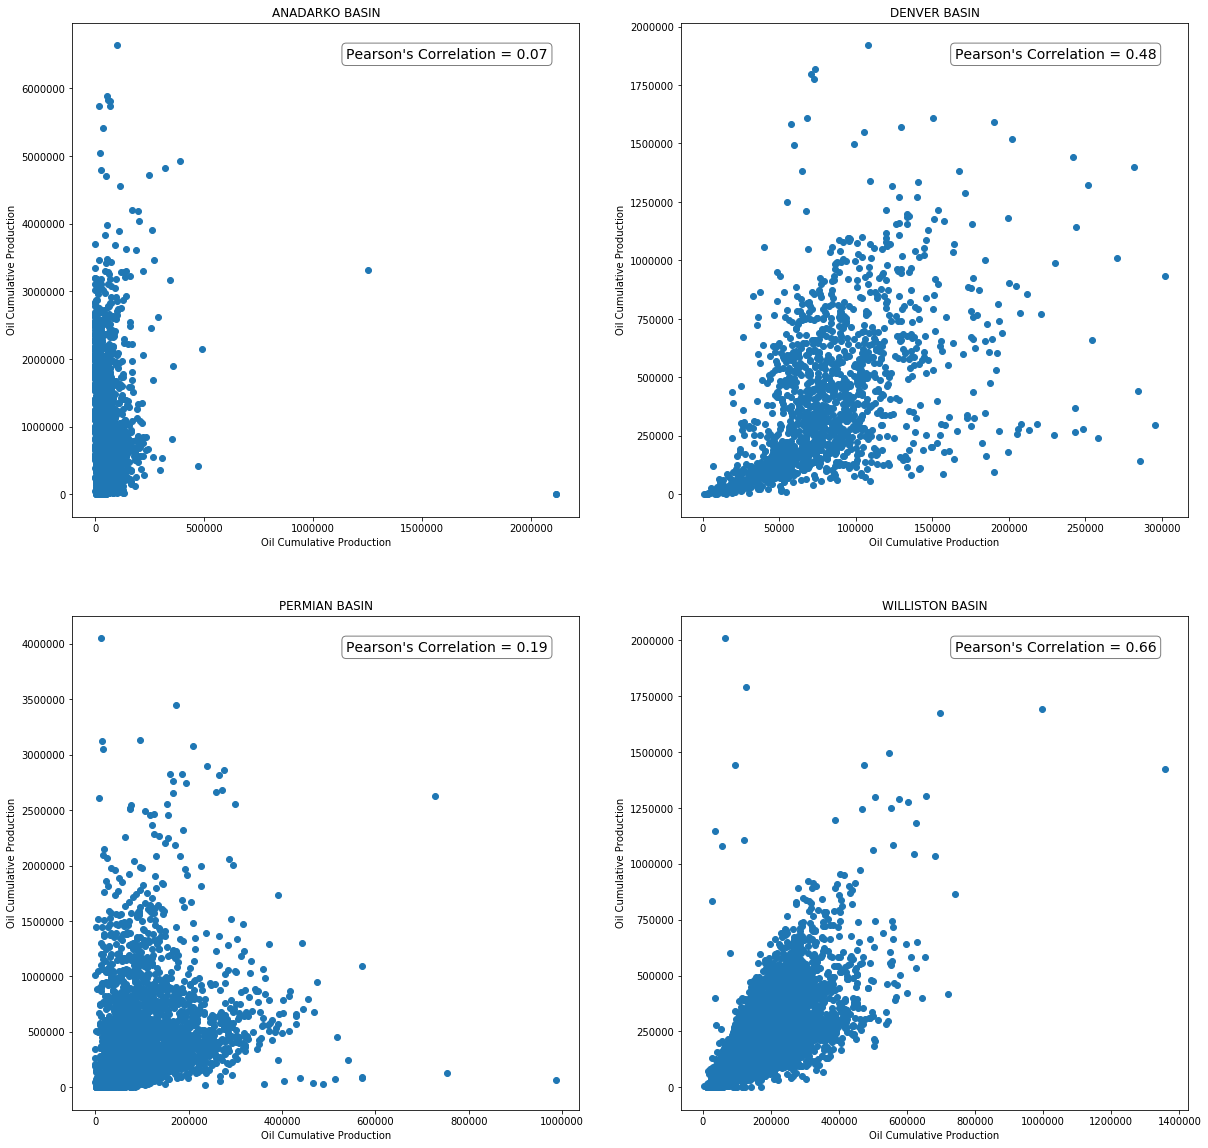

In [28]:
plt.rcParams["figure.figsize"] = 20,20

for i in range(len(basins)):
    ax1 = plt.subplot(2,2,i+1)
    ax1.scatter(liq[i], gas[i])
    ax1.set_title(basins[i])
    p_corr = gas[i].corr(liq[i], method='pearson')
    textstr = 'Pearson\'s Correlation = '+ str('%.2f'% p_corr)
    props = dict(boxstyle='round',facecolor='white', alpha=0.5)
    ax1.text(0.54, 0.95, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax1.set_xlabel('Oil Cumulative Production')
    ax1.set_ylabel('Oil Cumulative Production')

    
plt.savefig('Plot4.png')

In [46]:
wells_all_basins = wells_data.merge(indexed_prod_data, on='API')
sum_all_basins = wells_all_basins
sum_all_basins['TotalLiquid'] = wells_all_basins.groupby(['BasinName'])['Liquid'].transform('sum')
sum_all_basins =sum_all_basins.drop_duplicates(subset=['API'], keep='first', inplace=False)

In [30]:
def find_count_wells(basinName, table):
    return len(table[table['BasinName'] == basinName].drop_duplicates(subset=['API'], keep='first', inplace=False))

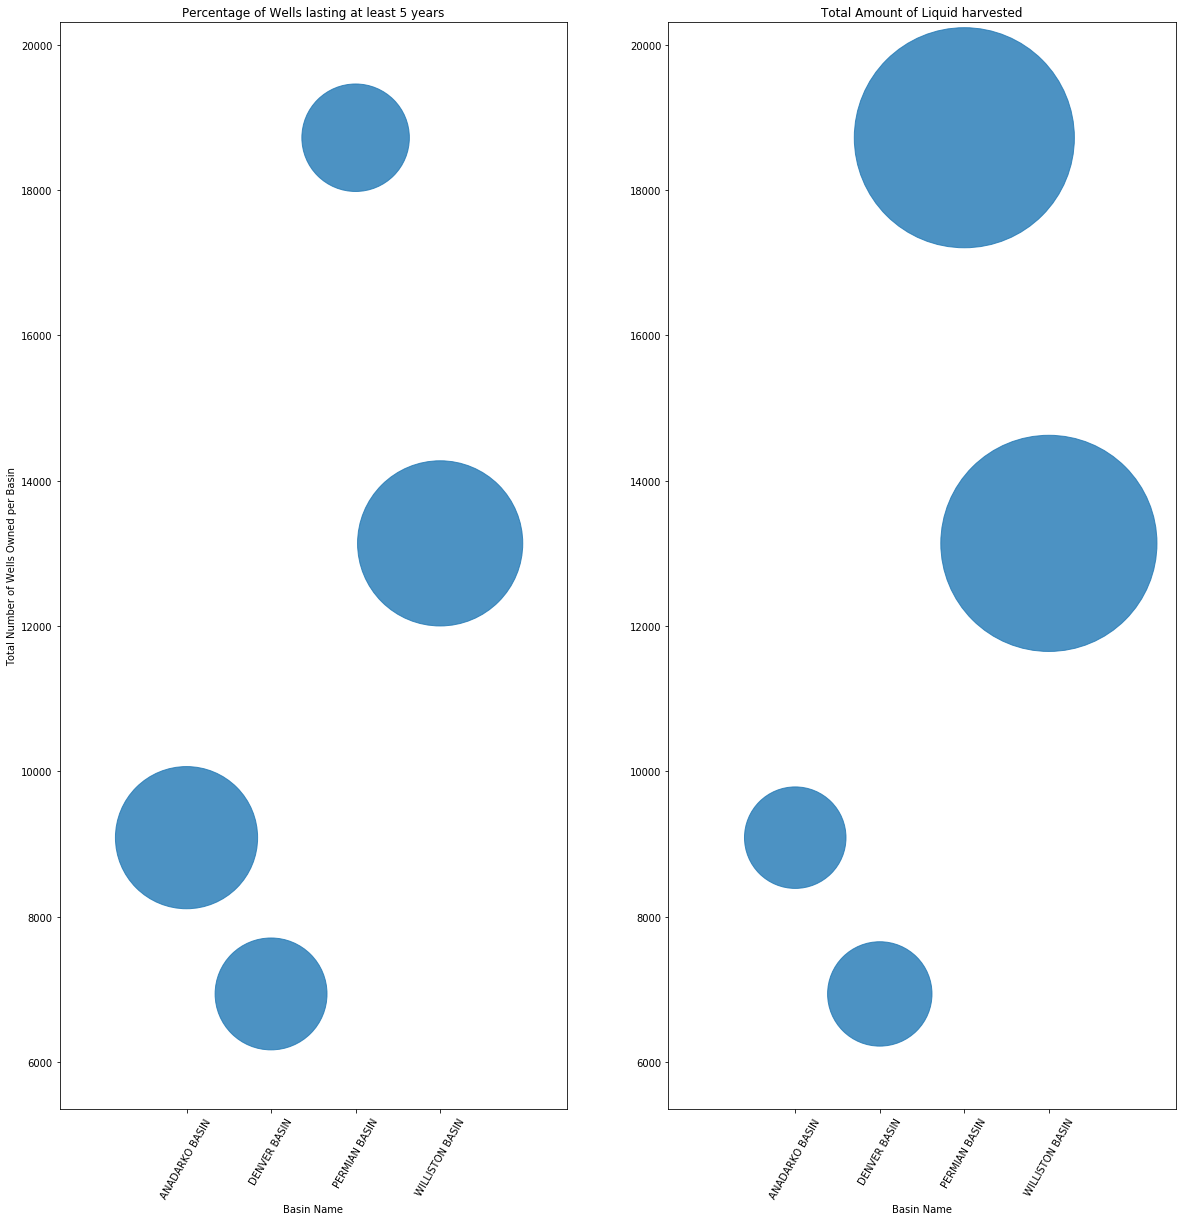

In [56]:
### Fifth plot, showing percentage of wells that last for at least five years out of all of the wells
## owned, also comparing the total volume of liquid
def getLiquid(table, basin):
    arr = (np.array(table[table['BasinName'] ==  basin]['TotalLiquid']))
    return arr[0]

count_all_wells_4basins = np.array([find_count_wells(y, indexed_wells_4basins) for y in basins])
count_five_years_wells_4basins = np.array([find_count_wells(y, five_years_data) for y in basins])

z_values = np.hstack([getLiquid(sum_all_basins, y) for y in basins])

y = count_all_wells_4basins
z = count_five_years_wells_4basins/count_all_wells_4basins
ax1 = plt.subplot(1,2,1)
size_scaler = 60000
ax1.scatter(np.arange(len(basins)), y, s=z*size_scaler, alpha = 0.8)
ax1.xaxis.set_ticks(np.arange(len(basins)))
ax1.xaxis.set_ticklabels(basins, rotation=60)
ax1 = plt.subplot(1,2,1)

ax2 = plt.subplot(1,2,2)
ax2.scatter(np.arange(len(basins)), y, s=z_values*0.00002, alpha = 0.8)
ax2.xaxis.set_ticks(np.arange(len(basins)))
ax2.xaxis.set_ticklabels(basins, rotation=60)


p_corr = gas[i].corr(liq[i], method='pearson')
x1, x2, y1, y2 = plt.axis()

ax1.set_title('Percentage of Wells lasting at least 5 years')
ax2.set_title('Total Amount of Liquid harvested')
ax1.set_xlabel('Basin Name')
ax1.set_ylabel('Total Number of Wells Owned per Basin')
ax1.set_xlim(-1.5, 4.5)
ax1.set_ylim(y1-1000, y2 + 1000)

ax2.set_xlabel('Basin Name')
ax2.set_xlim(-1.5, 4.5)
ax2.set_ylim(y1-1000, y2 + 1000)
plt.savefig('Plot5.png')
plt.show()